In [70]:
import os
os.chdir("/Users/melisande.croft/Library/CloudStorage/OneDrive-Htechnopole/Repos/kymograph-synthesis/src")

In [ ]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from microsim import schema as ms
from microsim.util import ortho_plot

from kymograph_synthesis.dynamics.particle_simulator.motion_state_collection import (
    MotionStateCollection,
)
from kymograph_synthesis.dynamics.system_simulator import (
    create_particle_simulators,
    run_simulation,
)
from kymograph_synthesis.render.static_path import (
    LinearPath,
    QuadraticBezierPath,
    PiecewiseQuadraticBezierPath,
)
from kymograph_synthesis.render.fluorophore_distributions import (
    ParticleSystem,
    SimplexNoise,
)
from kymograph_synthesis.sample_kymograph import inter_pixel_interp

# --- simulation params
n_steps = 64
particle_density = 8

# retro_speed_mode = 0.2e-2
# retro_speed_var = 0.02e-2 ** 2
retro_speed_mode = 2.4e-2
retro_speed_var = 0.4e-2**2
antero_speed_mode = 1.6e-2
antero_speed_var = 0.2e-2**2
velocity_noise_std = 0.32e-2

intensity_mode = 300
intensity_var = 50**2

n_spatial_samples = 96

# transition_matrix = {
#     MotionStateCollection.ANTEROGRADE: {
#         MotionStateCollection.ANTEROGRADE: 0.8,
#         MotionStateCollection.STATIONARY: 0.2,
#         MotionStateCollection.RETROGRADE: 0,
#     },
#     MotionStateCollection.STATIONARY: {
#         MotionStateCollection.ANTEROGRADE: 0.5,
#         MotionStateCollection.STATIONARY: 0.49,
#         MotionStateCollection.RETROGRADE: 0.01,
#     },
#     MotionStateCollection.RETROGRADE: {
#         MotionStateCollection.ANTEROGRADE: 0,
#         MotionStateCollection.STATIONARY: 0.01,
#         MotionStateCollection.RETROGRADE: 0.99,
#     },
# }
transition_matrix = {
    MotionStateCollection.ANTEROGRADE: {
        MotionStateCollection.ANTEROGRADE: 0.9,
        MotionStateCollection.STATIONARY: 0.1,
        MotionStateCollection.RETROGRADE: 0,
    },
    MotionStateCollection.STATIONARY: {
        MotionStateCollection.ANTEROGRADE: 0.1,
        MotionStateCollection.STATIONARY: 0.8,
        MotionStateCollection.RETROGRADE: 0.1,
    },
    MotionStateCollection.RETROGRADE: {
        MotionStateCollection.ANTEROGRADE: 0,
        MotionStateCollection.STATIONARY: 0.1,
        MotionStateCollection.RETROGRADE: 0.9,
    },
}

# --- generate particle properties from simulation
particles = create_particle_simulators(
    particle_density,
    antero_speed_mode,
    antero_speed_var,
    retro_speed_mode,
    retro_speed_var,
    intensity_mode=intensity_mode,
    intensity_var=intensity_var,
    intensity_half_life_mode=n_steps * 2,
    intensity_half_life_var=n_steps / 2,
    velocity_noise_std=velocity_noise_std,
    transition_matrix=transition_matrix,
    n_steps=n_steps,
)
particle_positions, particle_intensities, particle_states = run_simulation(
    n_steps, particles
)

In [121]:
# (np.array([0.1, 0.9]) - 0.1)/(0.9-0.1)
particle_positions_scaled = (particle_positions - 0.1)/(0.9 - 0.1)

In [122]:
particle_positions_scaled

array([[-1.70477275,  0.84920066, -0.25920785, ...,  0.57463   ,
        -0.93726396, -0.68117526],
       [-1.73320541,  0.817332  , -0.2448978 , ...,  0.60832359,
        -0.90809845, -0.6845339 ],
       [-1.75713125,  0.78482376, -0.2215859 , ...,  0.62541647,
        -0.88306798, -0.65755331],
       ...,
       [-2.15149035,  0.1023198 , -0.0993477 , ...,  0.78817472,
        -0.11406235, -0.46505285],
       [-2.13001906,  0.10548066, -0.12416012, ...,  0.79126303,
        -0.09359141, -0.49822589],
       [-2.1085897 ,  0.10720221, -0.15412382, ...,  0.79813382,
        -0.07261509, -0.52355027]])

In [123]:
path = PiecewiseQuadraticBezierPath(points=[
    np.array([0]),
    np.array([1])
])

In [124]:
path(np.array([0.5]))

array([[0.5]])

In [125]:
midpoints = particle_positions_scaled[:-1] + np.diff(particle_positions_scaled, axis=0)/2
len(midpoints)

63

In [126]:
kymograph_gt = np.zeros((n_steps, n_spatial_samples))
for t in range(n_steps):
    original_indices = np.round(particle_positions_scaled[t] * n_spatial_samples)
    if t != 0:
        # -- behind
        gradient = particle_positions_scaled[t] - midpoints[t - 1]
        interp_n = int(np.ceil(np.abs(gradient*n_spatial_samples).max())) + 1
        interp_positions = np.linspace(midpoints[t - 1], particle_positions_scaled[t], interp_n)
        for position in interp_positions:
            # indices = (indices - 0.1)/(0.9 - 0.1)
            indices = np.round(position * n_spatial_samples).astype(int)
            intensities = 1 - abs(original_indices - indices)/interp_n
            in_bounds = (0 <= indices) & (indices < n_spatial_samples)
            indices = indices[in_bounds]
            kymograph_gt[t, indices] = intensities[in_bounds]
            if (intensities < 0).any():
                pass

    if t != n_steps - 1:
        # --- in front
        gradient = midpoints[t] - particle_positions_scaled[t]
        interp_n = int(np.ceil(np.abs(gradient*n_spatial_samples).max())) + 1
        interp_positions = np.linspace(particle_positions_scaled[t], midpoints[t], interp_n)
        for position in interp_positions:
            # indices = (indices - 0.1)/(0.9 - 0.1)
            indices = np.round(position * n_spatial_samples).astype(int)
            intensities = 1 - abs(original_indices - indices)/interp_n
            in_bounds = (0 <= indices) & (indices < n_spatial_samples)
            indices = indices[in_bounds]
            kymograph_gt[t, indices] = intensities[in_bounds]
            if (intensities < 0).any():
                pass


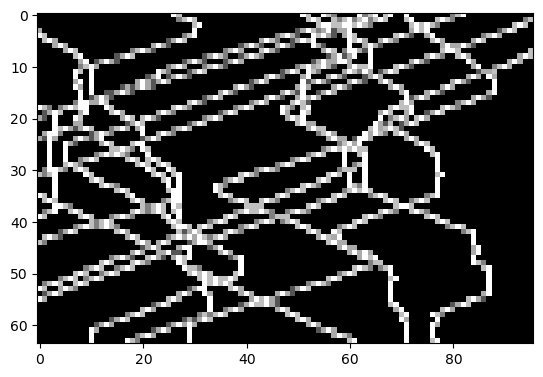

In [127]:
plt.imshow(kymograph_gt, "gray")

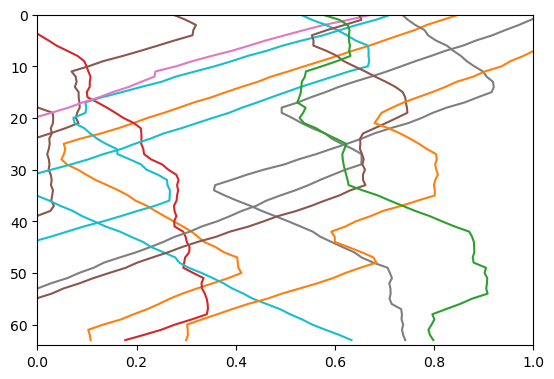

In [128]:
fig, ax = plt.subplots()
for particle_i in range(particle_positions_scaled.shape[1]):
    ax.plot(particle_positions_scaled[:,particle_i], np.arange(particle_positions_scaled.shape[0]))
ax.set_xlim(0, 1)
ax.set_ylim(n_steps, 0)
ax.set_aspect(1 / n_spatial_samples)

In [129]:
from kymograph_synthesis.gen_kymograph import gen_kymograph_gt

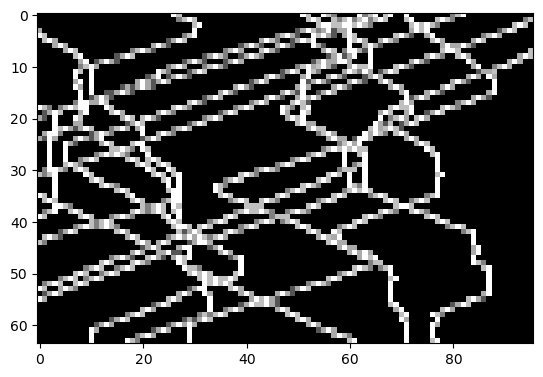

In [130]:
kymograph_gt = gen_kymograph_gt(particle_positions, n_spatial_samples, (0.1, 0.9))
plt.imshow(kymograph_gt, "gray")

MotionStateCollection.ANTEROGRADE
MotionStateCollection.STATIONARY
MotionStateCollection.RETROGRADE


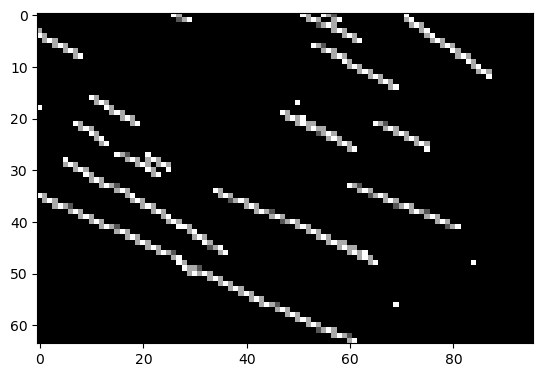

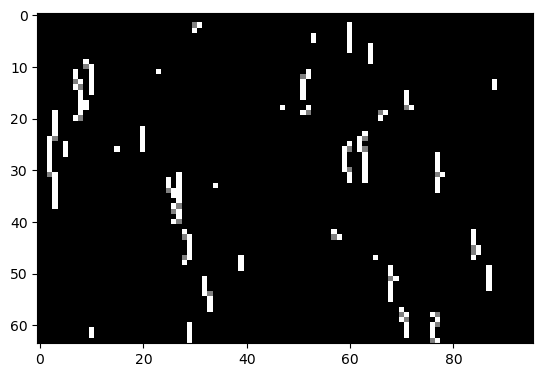

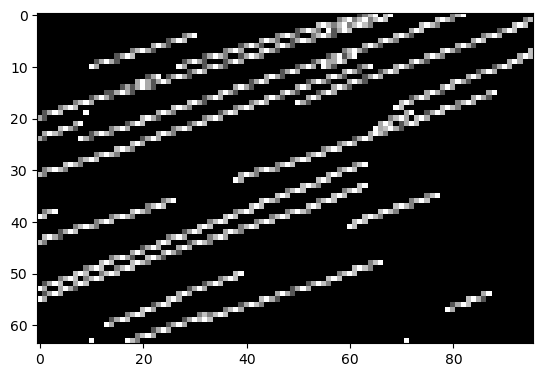

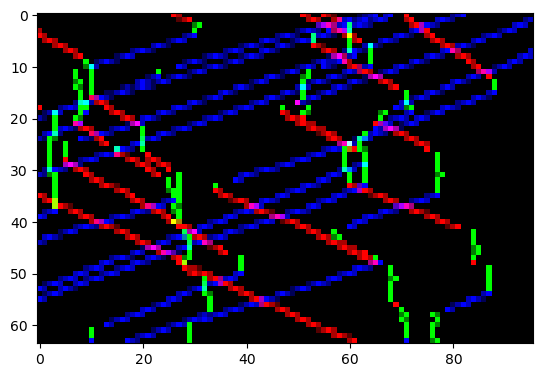

In [131]:
kymos = []
for state in MotionStateCollection:
    print(state)
    state_mask = particle_states==state.value
    state_positions = particle_positions.copy()
    state_positions[~state_mask] = np.nan
    state_kymo = gen_kymograph_gt(state_positions, n_spatial_samples, (0.1, 0.9))
    plt.figure()
    plt.imshow(state_kymo, "gray")
    kymos.append(state_kymo)
plt.figure()
plt.imshow(np.stack(kymos, axis=-1))

In [132]:
from numpy.typing import NDArray
from kymograph_synthesis.gen_kymograph import _calc_interp_indices, _calc_interp_intensities

In [133]:
def gen_kymograph_gt(
    positions: NDArray, states: NDArray[np.int_], spatial_res: int, path_range: tuple[float, float] = (0, 1)
) -> NDArray:
    n_steps = positions.shape[0]
    n_spatial_samples = spatial_res
    n_states = states.max()

    # placeholder
    kymograph_gt = np.zeros((n_steps, n_spatial_samples, n_states))

    positions_scaled = (positions - path_range[0]) / (path_range[1] - path_range[0])
    midpoints = positions_scaled[:-1] + np.diff(positions_scaled, axis=0) / 2
    for t in range(n_steps):
        if t != 0:
            for state_idx in range(n_states):
                indices = _calc_interp_indices(
                    spatial_res=spatial_res,
                    positions_0=midpoints[t - 1][states[t] == state_idx + 1],
                    positions_1=positions_scaled[t][states[t] == state_idx + 1],
                )
                intensities = _calc_interp_intensities(
                    interp_indices=indices, direction="left"
                )
                indices = indices.flatten()
                intensities = intensities.flatten()
                in_bounds = (0 <= indices) & (indices < n_spatial_samples)
                kymograph_gt[t, indices[in_bounds], state_idx] = intensities[in_bounds]
        if t != n_steps - 1:
            for state_idx in range(n_states):
                indices = _calc_interp_indices(
                    spatial_res=spatial_res,
                    positions_0=positions_scaled[t][states[t] == state_idx + 1],
                    positions_1=midpoints[t][states[t] == state_idx + 1],
                )
                intensities = _calc_interp_intensities(
                    interp_indices=indices, direction="right"
                )
                indices = indices.flatten()
                intensities = intensities.flatten()
                in_bounds = (0 <= indices) & (indices < n_spatial_samples)
                kymograph_gt[t, indices[in_bounds], state_idx] = intensities[in_bounds]
    return kymograph_gt

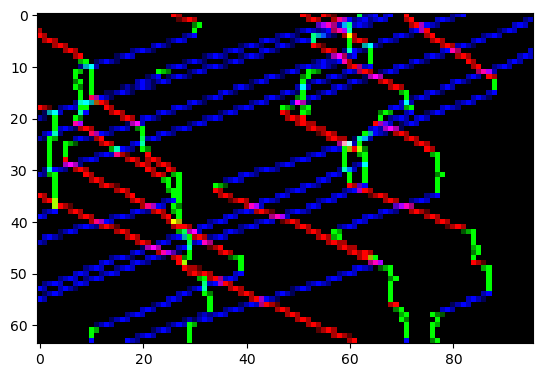

In [134]:
kymograph_gt = gen_kymograph_gt(particle_positions, particle_states, n_spatial_samples, (0.1, 0.9))
plt.imshow(kymograph_gt)